# Import Dataset

In [1]:
import gc
gc.collect()
import subprocess as sp
import os
def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

get_gpu_memory()

[11170]

In [2]:
import json
from nltk.corpus import stopwords
import re
import json
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
with open('test_dataset.json', 'r') as fp:
    test_dataset = json.load(fp)
with open('train_dataset.json', 'r') as fp:
    train_dataset = json.load(fp)
f = open('/data/data_codebook.json')
data_codebook = json.load(f)
super_set={}
for s in data_codebook:
    if s[2]!="domain_name":
        if s[2] not in super_set:
            super_set[s[2]]=[]
        if s[5] not in super_set[s[2]]:
            super_set[s[2]].append(s[5])

In [3]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix
sw = stopwords.words('english')

def clean_text(text):
    
    text = text.lower()
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    #text = re.sub(r"http", "",text)
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

In [4]:
def calculate_dataset_counts(dataset):
    count_dataset = {
        "general": {},
        "detailed": {}
    }
    
    for s in dataset:
        detailed_label = s['detailed_label']
        general_label = s["general_label"]
        
        if detailed_label not in count_dataset["detailed"]:
            count_dataset["detailed"][detailed_label] = 0
        count_dataset["detailed"][detailed_label] += 1

        if general_label not in count_dataset["general"]:
            count_dataset["general"][general_label] = 0
        count_dataset["general"][general_label] += 1
    
    return count_dataset

In [5]:
def extract_welfare_categories(dataset):
    welfare_categories = {}
    for key, value in super_set.items():
        if key != 'Welfare and Quality of Life':
            continue
        for category in value:
            welfare_categories[category] =dataset[category]
    
    return welfare_categories

welfare_categories_train=extract_welfare_categories(train_dataset)
welfare_categories_test=extract_welfare_categories(test_dataset)

In [6]:
def create_custom_dataset(balanced_dataset, total_limit, desired_percentage):
    used_sentences = set()
    dataset = []
    welfare_count = 0
    welfare_limit = int(total_limit * desired_percentage)
    category_limits = {category: 100 for category in balanced_dataset.keys()}

    # Calculate the total number of sentences in the dataset
    total_sentences = sum(len(v) for v in balanced_dataset.values())

    # First, add sentences from 'Environmental Protection'
    for sentence in balanced_dataset['Environmental Protection']:
        if len(dataset) >= welfare_limit:
            break

        if sentence not in used_sentences:
            per_line_dict = {
                "sentence": sentence,
                "detailed_label": 'Environmental Protection',
                "general_label": 'Welfare and Quality of Life'
            }
            dataset.append(per_line_dict)
            used_sentences.add(sentence)
            welfare_count += 1

    # Then, add sentences from other categories
    while len(dataset) < total_limit:
        for category, sentences in balanced_dataset.items():
            if len(dataset) >= total_limit:
                break
            if category != 'Environmental Protection':
                for key, value in super_set.items():
                    if category in value:
                        super_label = key

                category_limit = min(len(sentences), category_limits[category])

                limit = min(100, category_limit)

                for sentence in sentences:
                    if limit == 0 or len(dataset) >= total_limit:
                        break

                    if sentence not in used_sentences:
                        per_line_dict = {
                            "sentence": sentence,
                            "detailed_label": category,
                            "general_label": super_label
                        }
                        dataset.append(per_line_dict)
                        used_sentences.add(sentence)
                        limit -= 1
                        category_limits[category] += 100

    return dataset


In [7]:
"Experiment 1"
total_limit = 56000
desired_percentage = 0.3

dataset = create_custom_dataset(welfare_categories_train, total_limit, desired_percentage)

print("Total sentences in the dataset:", len(dataset))

# Usage example:
# Assuming you have the 'dataset' variable containing the dataset obtained from the create_custom_dataset function
# Replace this with the actual dataset you want to count.
count_dataset = calculate_dataset_counts(dataset)
print(count_dataset["general"])
print(sum(count_dataset["general"].values()))
print(len(count_dataset["detailed"].keys()))
print(count_dataset["detailed"])

Total sentences in the dataset: 56000
{'Welfare and Quality of Life': 56000}
56000
11
{'Environmental Protection': 16800, 'Culture: Positive': 8300, 'Equality: Positive': 8294, 'Welfare State Expansion': 8200, 'Welfare State Limitation': 5380, 'Education Expansion': 8200, 'Education Limitation': 515, 'Private-Public Mix in Culture: Positive': 36, 'Private-Public Mix in Social Justice: Positive': 1, 'Private-Public Mix in Welfare: Positive': 227, 'Private-Public Mix in Education: Positive': 47}


# RoBerta model

In [8]:
# load tokens
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

In [9]:
dataframe = pd.DataFrame(data=(dataset))
dataframe=shuffle(dataframe).dropna()
dataframe

,sentence,detailed_label,general_label
35681,That all municipalities offer cultural cards ...,Culture: Positive,Welfare and Quality of Life
12027,"The erosion of Swiss biodiversity continues, ...",Environmental Protection,Welfare and Quality of Life
2704,"For environmentalists, the main provisions are:",Environmental Protection,Welfare and Quality of Life
25200,DPA in the field of art galleries includes th...,Culture: Positive,Welfare and Quality of Life
7441,In this direction of guaranteeing animal welf...,Environmental Protection,Welfare and Quality of Life
...,...,...,...
13182,"A ""Program of measures to achieve the environ...",Environmental Protection,Welfare and Quality of Life
38431,"as well as reinforcing Home Palliative Care, ...",Welfare State Limitation,Welfare and Quality of Life
44363,Taking away the ability to work opens up a hu...,Welfare State Expansion,Welfare and Quality of Life
26964,First of all: what does 'socialisation of car...,Welfare State Limitation,Welfare and Quality of Life


In [10]:
train_sentences=list(dataframe["sentence"])
train_labels=[]
for s in list(dataframe["detailed_label"]):
    if s=='Environmental Protection':
        number=1
    else:
        number=0
    train_labels.append(number)

train_sentences_cleaned=[]
for s in list(dataframe["sentence"]):
    cleaned=clean_text(s)
    train_sentences_cleaned.append(cleaned)

max:  135
min:  2


Text(0.5, 1.0, 'The distribution of sequence length, when the percentage of Welfare sentences is: 30.0%')

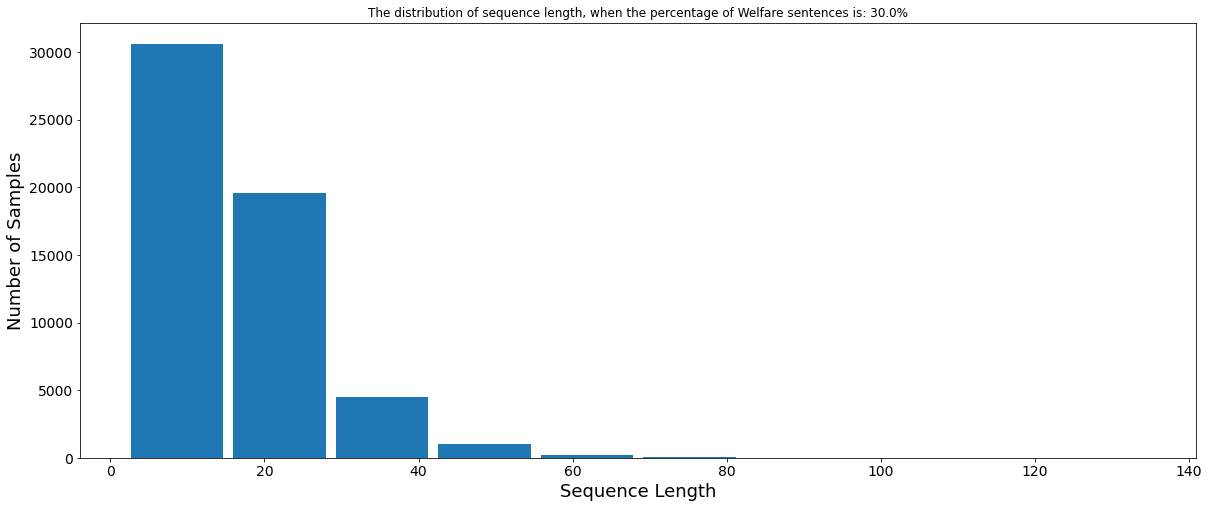

In [11]:
# tokenize the text feature 
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            train_sentences_cleaned, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True      
                   )
# collect tokenized sentence length 
token_sentence_length = [len(x) for x in tokenized_feature_raw['input_ids']]
print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))
# plot the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.hist(token_sentence_length, rwidth = 0.9)
plt.xlabel('Sequence Length', fontsize = 18)
plt.ylabel('Number of Samples', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("The distribution of sequence length, when the percentage of Welfare sentences is: "+str(desired_percentage*100)+"%")

In [12]:
# tokenize features 
MAX_LEN = 135
tokenized_feature = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            train_sentences_cleaned, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            # Add empty tokens if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Truncate all sentences to max length
                            truncation=True,
                            # Set the maximum length
                            max_length = MAX_LEN, 
                            # Return attention mask
                            return_attention_mask = True,
                            # Return pytorch tensors
                            return_tensors = 'pt')

In [13]:
# Use 80% for training and 20% for validation
from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(tokenized_feature['input_ids'], 
                                                                                                             train_labels,
                                                                                                                    tokenized_feature['attention_mask'],
                                                                                                      random_state=42, test_size=0.2, stratify=train_labels)

In [14]:
# load base package for the tasks from pytorch
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# define batch_size
batch_size = 16
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# Create the DataLoader for our test set
validation_data = TensorDataset(validation_inputs, validation_masks, torch.tensor(validation_labels))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [15]:
# load base package for the tasks from pytorch
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [16]:
# BertForSequenceClassification
from transformers import XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", 
    # Specify number of classes
    num_labels = len(set(train_labels)), 
    # Whether the model returns attentions weights
    output_attentions = False,
    # Whether the model returns all hidden-states 
    output_hidden_states = False
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Receive the full size of the new word
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 250002. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(250002, 768, padding_idx=1)

In [18]:
# Optimizer & Learning Rate Scheduler
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

/home/users/yabdul/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
# Number of training epochs
epochs = 3
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [20]:
# tell pytorch to run this model on GPU
model.cuda()

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0): XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tr

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [17]:
# Function to calculate the accuracy of our predictions vs labels
import time
import datetime
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
torch.cuda.empty_cache()
# start training from here

In [23]:
import random
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)        
        loss = output.loss
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            output= model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()
        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model, 'Roberta_30percent_TwoStep_Detailed')
        best_eval_accuracy = avg_val_accuracy
    #print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    #print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...

  Average training loss: 0.23
  Training epcoh took: 0:12:44

Running Validation...
  Accuracy: 0.94

======== Epoch 2 / 3 ========
Training...

  Average training loss: 0.17
  Training epcoh took: 0:12:44

Running Validation...
  Accuracy: 0.94

======== Epoch 3 / 3 ========
Training...

  Average training loss: 0.15
  Training epcoh took: 0:12:44

Running Validation...
  Accuracy: 0.94

Training complete!
Total training took 0:41:33 (h:mm:ss)


In [18]:
model = torch.load('Roberta_30percent_TwoStep_Detailed')

# Test the model

In [19]:
print("-----Now test the model on another unseen test sets--------")
test_dataframe=[]
for k,v in welfare_categories_test.items():
    for key, value in super_set.items():
        if k in value:
            super_label = key
    for s in v:
            per_line_dict = {}
            per_line_dict["sentence"] = s
            per_line_dict["detailed_label"] = k
            per_line_dict["general_label"] = super_label
            test_dataframe.append(per_line_dict)

test_dataframe = pd.DataFrame(data=(test_dataframe))
test_dataframe=shuffle(test_dataframe).dropna()
test_dataframe

-----Now test the model on another unseen test sets--------


,sentence,detailed_label,general_label
24153,Instead of facing the austerity policies from ...,Welfare State Expansion,Welfare and Quality of Life
16272,pensions in payment will continue to be finan...,Welfare State Expansion,Welfare and Quality of Life
2625,We have ensured an environmental policy awake...,Environmental Protection,Welfare and Quality of Life
18274,Regionalization should also be followed by th...,Welfare State Expansion,Welfare and Quality of Life
760,FOR AN ECO-SOCIALIST ALTERNATIVE,Environmental Protection,Welfare and Quality of Life
...,...,...,...
18816,supervision over the execution of works is ca...,Welfare State Expansion,Welfare and Quality of Life
19249,The Green Liberals are striving for autonomou...,Welfare State Expansion,Welfare and Quality of Life
11375,Property needs appreciation!,Equality: Positive,Welfare and Quality of Life
25785,replacing school dropout and general tuition ...,Education Expansion,Welfare and Quality of Life


In [20]:
test_sentences_cleaned=[]
for s in list(test_dataframe["sentence"]):
    cleaned=clean_text(s)
    test_sentences_cleaned.append(cleaned)

test_labels_numbers=[]
for s in list(test_dataframe["detailed_label"]):
    if s=='Environmental Protection':
        number=1
    else:
        number=0
    test_labels_numbers.append(number)

In [21]:
len(test_sentences_cleaned)==len(test_labels_numbers)

True

max:  147
min:  2


Text(0.5, 1.0, 'Test set.The distribution of sequence length, when the percentage of Welfare sentences is: 30.0%')

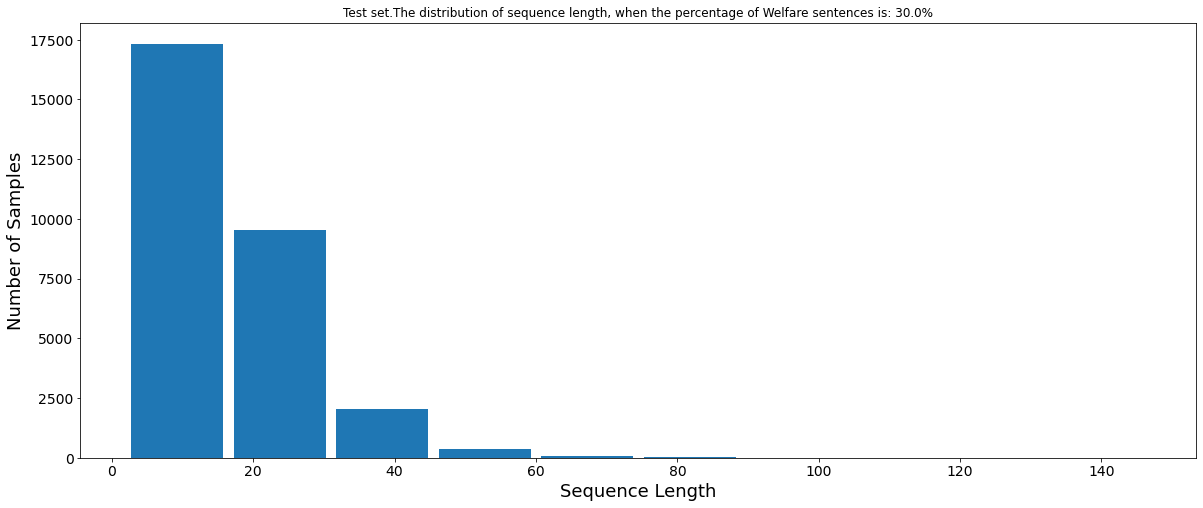

In [22]:
# tokenize the text feature 
test_tokenized_feature = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            test_sentences_cleaned, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True      
                   )
# collect tokenized sentence length 
token_sentence_length = [len(x) for x in test_tokenized_feature['input_ids']]
print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))
# plot the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.hist(token_sentence_length, rwidth = 0.9)
plt.xlabel('Sequence Length', fontsize = 18)
plt.ylabel('Number of Samples', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("Test set.The distribution of sequence length, when the percentage of Welfare sentences is: "+str(desired_percentage*100)+"%")

In [23]:
# tokenize features 
MAX_LEN = 147
test_tokenized_feature = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            test_sentences_cleaned, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            # Add empty tokens if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Truncate all sentences to max length
                            truncation=True,
                            # Set the maximum length
                            max_length = MAX_LEN, 
                            # Return attention mask
                            return_attention_mask = True,
                            # Return pytorch tensors
                            return_tensors = 'pt'     )

In [24]:
# Create the DataLoader for our test set
validation_data = TensorDataset(test_tokenized_feature['input_ids'], test_tokenized_feature['attention_mask'], torch.tensor(test_labels_numbers))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [25]:
# Test
import numpy as np
t0 = time.time()
# model in validation mode
model.eval()
# save prediction
predictions,true_labels =[],[]
# evaluate data for one epoch
for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # validation
    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
    # get output
    logits = outputs[0]
    # move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    final_prediction = np.argmax(logits, axis=-1).flatten()
    predictions.append(final_prediction)
    true_labels.append(label_ids)
    
print('total time used is: {0:.2f} s'.format(time.time() - t0))

total time used is: 134.61 s


In [26]:
# convert numeric label to string
final_prediction_list = np.concatenate(predictions)
# Evaluate accuracy
accuracy = accuracy_score(test_labels_numbers, final_prediction_list)

# Evaluate F1-score
f1_score = f1_score(test_labels_numbers, final_prediction_list, average='weighted')

# Evaluate balanced accuracy
balanced_accuracy = balanced_accuracy_score(test_labels_numbers, final_prediction_list)


# Print evaluation metrics for Linear SVC on the unseen test set
print("Linear SVC Accuracy on Unseen Test Set:", round(accuracy,2))
print("Linear SVC F1-Score on Unseen Test Set:", round(f1_score,2))
print("Linear SVC Balanced Accuracy on Unseen Test Set:", round(balanced_accuracy,2))
print()

# Print classification report and confusion matrix for Linear SVC on the unseen test set
print("Linear SVC Classification Report on Unseen Test Set:")
print(classification_report(test_labels_numbers, final_prediction_list))

print("Linear SVC Confusion Matrix on Unseen Test Set:")
print(confusion_matrix(test_labels_numbers, final_prediction_list))

Linear SVC Accuracy on Unseen Test Set: 0.94
Linear SVC F1-Score on Unseen Test Set: 0.94
Linear SVC Balanced Accuracy on Unseen Test Set: 0.92

Linear SVC Classification Report on Unseen Test Set:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     21914
           1       0.89      0.89      0.89      7475

    accuracy                           0.94     29389
   macro avg       0.93      0.92      0.93     29389
weighted avg       0.94      0.94      0.94     29389

Linear SVC Confusion Matrix on Unseen Test Set:
[[21104   810]
 [  846  6629]]
